## Entropy experiment

In [1]:
import torch

In [2]:
hidden_state = torch.randn(4, 45, 50)

In [3]:
def entropy(x):
    x = x.clone().to(dtype=torch.float64)
    max_x = torch.max(x, dim=2, keepdim=True).values
    
    exp_x_sub_max = torch.exp(x - max_x)
    A = torch.sum(exp_x_sub_max, dim=2, keepdim=True)    # sum of exp(x_i)
    
    B = torch.sum(x * exp_x_sub_max, dim=2, keepdim=True)  # sum of x_i * exp(x_i)

    return (torch.log(A) - max_x - B/A).squeeze()

In [4]:
entropy(hidden_state)

tensor([[-9.0075e-01, -1.7691e+00, -7.2691e-01, -5.4170e-01, -4.4090e-01,
          3.8102e-03, -9.2757e-01, -3.2611e-02, -1.8527e+00, -4.2516e-01,
          1.1716e-01,  1.6506e-01, -3.4043e+00, -1.5693e-01, -6.7494e-01,
         -3.2462e+00, -1.8543e+00, -6.5689e-01, -8.5172e-01, -1.7569e+00,
         -7.5753e-01, -2.5886e+00,  8.7120e-01, -9.5275e-01, -2.8231e-01,
         -1.5377e+00,  3.0492e-01, -5.1948e-01, -4.6186e-01, -1.3262e+00,
         -1.2145e+00,  7.4967e-01, -9.4609e-01, -3.8689e-01,  2.4969e-02,
         -1.1314e+00, -3.0569e-01,  5.2007e-01, -5.3015e-01, -7.6512e-02,
         -1.9008e+00, -7.0316e-01, -1.9887e+00, -1.7140e+00,  2.9589e-01],
        [-1.8484e+00, -1.9622e+00, -1.1772e+00, -1.0154e+00, -1.7693e+00,
         -6.7330e-01, -2.5699e-01, -4.3016e-01, -1.8881e+00, -2.2415e+00,
         -5.0211e-01,  2.0287e-01, -9.5233e-01, -8.9187e-01,  2.6569e-01,
         -7.8853e-01, -2.7260e+00, -3.2651e+00,  6.9314e-01, -9.6978e-01,
          6.7187e-02, -4.0429e-01, -2

## Print entropy heatmap

In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np
import os

import matplotlib
import matplotlib as mpl
import csv

In [2]:
num_layer = 32
num_token = 84

# min_beam = True, checks the min entropy over all beams
min_beam = True
# only if min_beam = False, which beams will affect the result
which_beam = 0

entropy_save_prefix = 'entropy'
entropy_save_dir = '/home/u4874056/LLM_entropy/entropy_dump'

layers = list(range(num_layer))
tokens = list(range(num_token))

In [3]:
# x is a tokens * layers tensor
x = torch.tensor([]).to('cuda:0')
for token_idx in range(num_token):
    temp_x = torch.tensor([]).to('cuda:0')
    
    for layer_idx in range(num_layer):
        dump_dir = f'{entropy_save_dir}/{entropy_save_prefix}_{token_idx}_{layer_idx}.pt'
        if not os.path.isfile(dump_dir):
            continue

        hidden_state = torch.load(dump_dir).to('cuda:0')
        
        if min_beam == True:
            if temp_x.shape == torch.Size([0]):
                temp_x = torch.cat((temp_x, torch.min(hidden_state, 0).values), 0)
                temp_x = temp_x[None, :]
            else:
                temp_x = torch.cat((temp_x, torch.min(hidden_state, 0).values[None, :]), 0)
        else:
            if temp_x.shape == torch.Size([0]):
                temp_x = torch.cat((temp_x, hidden_state[which_beam]), 0)
                temp_x = temp_x[None, :]
            else:
                temp_x = torch.cat((temp_x, hidden_state[which_beam][None, :]), 0)

    x = torch.cat((x, temp_x), 1)

In [4]:
print(x.shape)

torch.Size([32, 84])


In [5]:
entropy = x.cpu().numpy()[:num_layer,:num_token]

print(entropy[0][:][:])

[8.18439922 8.31620368 8.31237863 8.31353401 8.31709693 8.31547003
 8.31705076 8.31434634 8.31730923 8.30738019 8.31710733 8.31525422
 8.31730864 8.3166324  8.31724959 8.31744083 8.31712323 8.31744899
 8.3134657  8.31737406 8.31530554 8.31344872 8.31364922 8.31686342
 8.31720484 8.31695506 8.317346   8.31659485 8.31306821 8.31665231
 8.31728253 8.31729178 8.31713033 8.31714337 8.31718056 8.31721773
 8.31730967 8.31611331 8.31359207 8.31280043 8.31692675 8.31721512
 8.31728471 8.31664424 8.31332544 8.31253433 8.31686353 8.31582765
 8.31675233 8.31632354 8.31693923 8.31708571 8.31680147 8.31683993
 8.31682745 8.31713267 8.31678422 8.31564621 8.31706959 8.31567282
 8.31706566 8.31696586 8.31673583 8.31699075 8.31577466 8.31655311
 8.31574553 8.31712582 8.31701793 8.31708366 8.31707305 8.31578344
 8.31713371 8.31594955 8.31715885 8.31712321 8.3160768  8.31627217
 8.31693453 8.31730424 8.3166487  8.31545067 8.31714415 8.31587801]


<Figure size 1000x600 with 0 Axes>

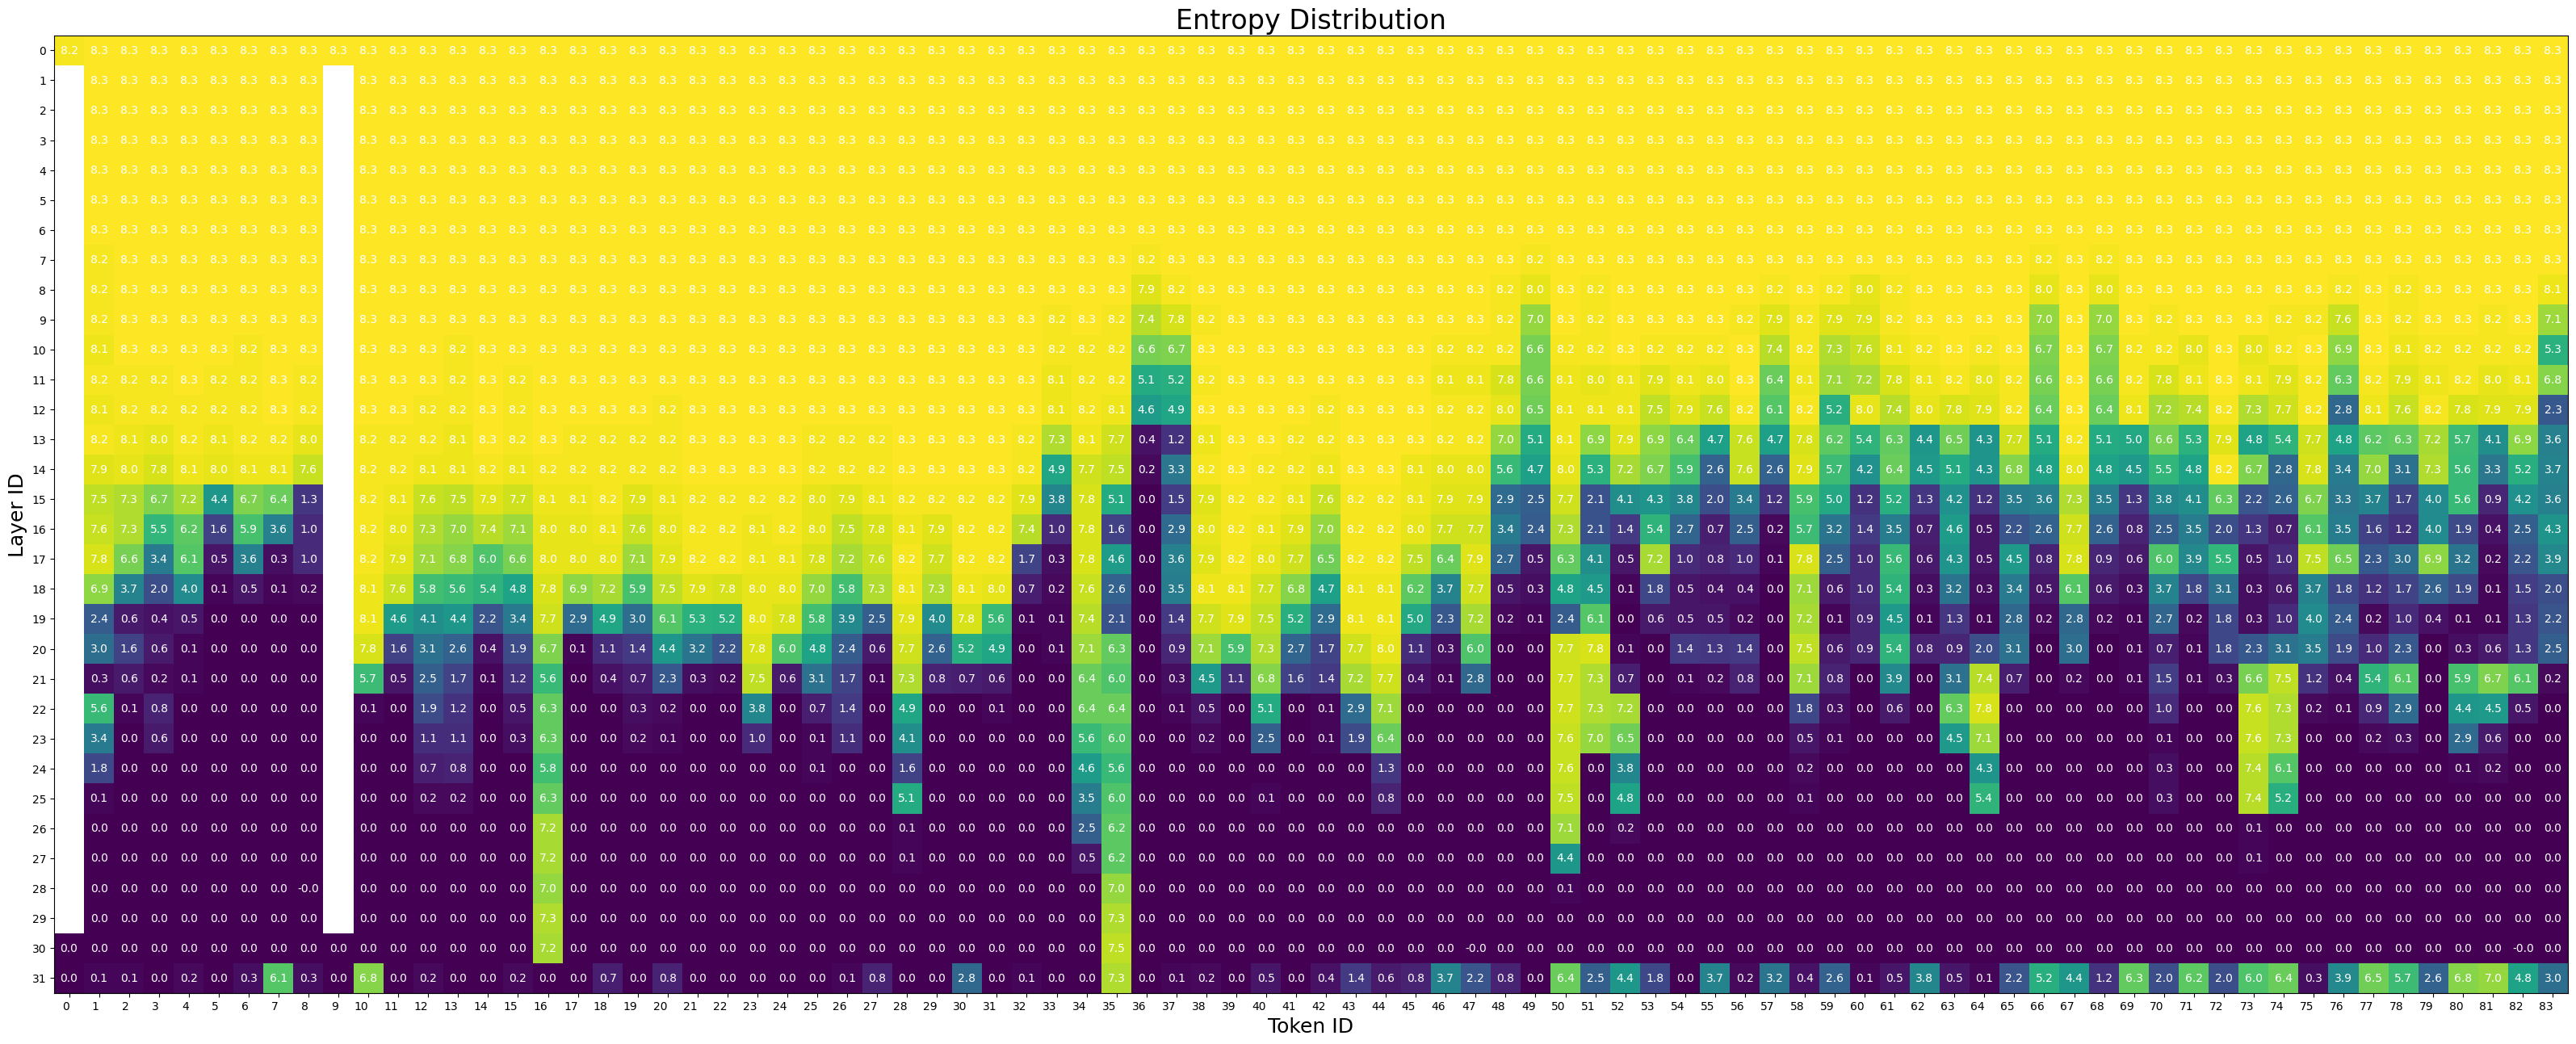

In [6]:
entropy = np.round(entropy, 1)

plt.figure(figsize=(10,6))
fig, ax = plt.subplots(1, figsize=(num_layer, num_token))
im = ax.imshow(entropy)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(tokens)), labels=tokens)
ax.set_yticks(np.arange(len(layers)), labels=layers)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in layers:
    for j in tokens:
        text = ax.text(j, i, entropy[i, j],
                       ha="center", va="center", color="w")

ax.set_title('Entropy Distribution', fontsize=24)
plt.xlabel('Token ID', fontsize=18)
plt.ylabel('Layer ID', fontsize=18)

fig.tight_layout()
plt.show()